In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import CLIPModel, CLIPProcessor
from peft import LoraConfig, get_peft_model
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

# --- DATASET DECLARATION ---
class CrisisHumanitarianDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        
        # EXACT SYNC: Mapping the 5 labels found in your file
        self.label_map = {
            "infrastructure_and_utility_damage": 0,
            "other_relevant_information": 1,
            "not_humanitarian": 2,
            "rescue_volunteering_or_donation_effort": 3,
            "affected_individuals": 4
        }
        
        # Filter to ensure we only keep these 5 classes
        self.data = self.data[self.data['label'].isin(self.label_map.keys())].reset_index(drop=True)
        print(f"Loaded {len(self.data)} rows from {os.path.basename(filepath)}")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        rel_path = str(row['image']).replace('\\', '/').lstrip('/')
        img_path = os.path.normpath(os.path.join(self.img_dir, rel_path))
        
        if not os.path.exists(img_path): return None
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long)
            }
        except Exception: return None

def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

In [5]:
class GatedHumanitarianFusion(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.text_proj = nn.Linear(embed_dim, 512)
        self.image_proj = nn.Linear(embed_dim, 512)
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, 256), nn.GELU(), nn.Linear(256, 2), nn.Softmax(dim=1))
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, t_f, i_f):
        t_p, i_p = F.gelu(self.text_proj(t_f)), F.gelu(self.image_proj(i_f))
        weights = self.gate(torch.cat([t_f, i_f], dim=1))
        return self.layer_norm((weights[:, 0:1] * t_p) + (weights[:, 1:2] * i_p))

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha) if alpha is not None else None

    def forward(self, inputs, targets):
        log_p = F.log_softmax(inputs, dim=-1)
        ce_loss = F.nll_loss(log_p, targets, reduction='none', weight=self.alpha.to(inputs.device) if self.alpha is not None else None)
        return ((1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss).mean()

class HumanitarianVLM(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)
        self.fusion = GatedHumanitarianFusion()
        self.classifier = nn.Sequential(nn.Linear(512, 512), nn.BatchNorm1d(512), nn.GELU(), nn.Dropout(0.4), nn.Linear(512, num_classes))

    def forward(self, ids, mask, pix):
        t_f = F.normalize(self.clip.get_text_features(input_ids=ids, attention_mask=mask), p=2, dim=-1)
        i_f = F.normalize(self.clip.get_image_features(pixel_values=pix), p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

In [6]:
# --- INITIALIZATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

IMG_ROOT = r"F:\research\chatbot\D\Multi-modal-codes" 
DATA_DIR = r"data\CrisisMMD\crisismmd_datasplit_all\crisismmd_datasplit_agreed_label"

# Data Loaders
train_loader = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_train.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
dev_loader   = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_dev.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)
test_loader  = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_test.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

# Model and PEFT (LoRA)
model = HumanitarianVLM().to(device)
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

# Differential Optimizer
optimizer = optim.AdamW([
    {'params': model.base_model.clip.parameters(), 'lr': 1e-6, 'weight_decay': 0.05},
    {'params': model.base_model.fusion.parameters(), 'lr': 5e-4},
    {'params': model.base_model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

criterion = FocalLoss(alpha=[1.5, 0.8, 0.6, 1.8, 2.0], gamma=2.0)
scaler = GradScaler('cuda')

# --- TRAINING EXECUTION ---
best_val_f1 = 0
for epoch in range(15):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/15")
    for batch in loop:
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in dev_loader:
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy()); val_labels.extend(b['label'].numpy())
    
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    print(f"📈 Dev Macro-F1: {val_f1:.4f}")
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_humanitarian_model.pth')
        print("⭐ Saved Best Model!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded 6126 rows from task_humanitarian_text_img_agreed_lab_train.tsv
Loaded 998 rows from task_humanitarian_text_img_agreed_lab_dev.tsv
Loaded 955 rows from task_humanitarian_text_img_agreed_lab_test.tsv


Epoch 1/15:  26%|██▌       | 100/383 [01:31<05:50,  1.24s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/15: 100%|██████████| 383/383 [06:49<00:00,  1.07s/it]


📈 Dev Macro-F1: 0.1669
⭐ Saved Best Model!


Epoch 2/15:  39%|███▉      | 149/383 [01:59<03:52,  1.01it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/15: 100%|██████████| 383/383 [05:06<00:00,  1.25it/s]


📈 Dev Macro-F1: 0.2426
⭐ Saved Best Model!


Epoch 3/15:  41%|████      | 156/383 [01:05<01:26,  2.61it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/15: 100%|██████████| 383/383 [02:41<00:00,  2.37it/s]


📈 Dev Macro-F1: 0.3165
⭐ Saved Best Model!


Epoch 4/15:  48%|████▊     | 182/383 [01:16<01:23,  2.42it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/15: 100%|██████████| 383/383 [02:42<00:00,  2.35it/s]


📈 Dev Macro-F1: 0.3882
⭐ Saved Best Model!


Epoch 5/15:  24%|██▍       | 91/383 [00:38<02:00,  2.42it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/15: 100%|██████████| 383/383 [02:40<00:00,  2.39it/s]


📈 Dev Macro-F1: 0.4416
⭐ Saved Best Model!


Epoch 6/15:  90%|█████████ | 345/383 [02:52<00:15,  2.44it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/15: 100%|██████████| 383/383 [03:11<00:00,  2.00it/s]


📈 Dev Macro-F1: 0.5124
⭐ Saved Best Model!


Epoch 7/15:  10%|█         | 40/383 [00:16<02:21,  2.42it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/15: 100%|██████████| 383/383 [02:39<00:00,  2.41it/s]


📈 Dev Macro-F1: 0.5307
⭐ Saved Best Model!


Epoch 8/15:  91%|█████████ | 348/383 [02:25<00:14,  2.36it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/15: 100%|██████████| 383/383 [02:40<00:00,  2.38it/s]


📈 Dev Macro-F1: 0.5719
⭐ Saved Best Model!


Epoch 9/15:  59%|█████▊    | 225/383 [01:33<01:08,  2.32it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/15: 100%|██████████| 383/383 [02:43<00:00,  2.35it/s]


📈 Dev Macro-F1: 0.5963
⭐ Saved Best Model!


Epoch 10/15:  42%|████▏     | 160/383 [02:24<03:29,  1.07it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/15: 100%|██████████| 383/383 [05:40<00:00,  1.12it/s]


📈 Dev Macro-F1: 0.6264
⭐ Saved Best Model!


Epoch 11/15:  67%|██████▋   | 257/383 [03:48<01:46,  1.19it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/15: 100%|██████████| 383/383 [05:39<00:00,  1.13it/s]


📈 Dev Macro-F1: 0.6243


Epoch 12/15:  65%|██████▌   | 250/383 [01:43<00:55,  2.41it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/15: 100%|██████████| 383/383 [02:38<00:00,  2.41it/s]


📈 Dev Macro-F1: 0.6391
⭐ Saved Best Model!


Epoch 13/15:   3%|▎         | 11/383 [00:04<02:35,  2.39it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/15: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]


📈 Dev Macro-F1: 0.6623
⭐ Saved Best Model!


Epoch 14/15:  43%|████▎     | 163/383 [02:26<03:02,  1.21it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/15: 100%|██████████| 383/383 [05:18<00:00,  1.20it/s]


📈 Dev Macro-F1: 0.6786
⭐ Saved Best Model!


Epoch 15/15:  83%|████████▎ | 316/383 [03:29<00:25,  2.61it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/15: 100%|██████████| 383/383 [04:01<00:00,  1.59it/s]


📈 Dev Macro-F1: 0.6922
⭐ Saved Best Model!


In [7]:
import torch.nn.functional as F

# 1. Load the best weights saved during training
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true = []
y_pred = []
y_probs = [] # Raw probabilities for ROC/AUC

print("🏃 Running Final Evaluation on Test Set...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Evaluation"):
        if batch is None: continue
        
        # Move to GPU
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        labels = batch['label'].numpy()
        
        # Get raw logits
        logits = model(ids, mask, pix)
        
        # Calculate Softmax probabilities
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store for analytics
        y_probs.extend(probs)
        y_pred.extend(preds)
        y_true.extend(labels)

print("✅ Analytics data captured successfully.")

🏃 Running Final Evaluation on Test Set...


Final Evaluation: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]

✅ Analytics data captured successfully.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

def generate_research_analytics(history, y_true, y_pred, y_probs, label_names):
    """Generates high-resolution visuals for Journal Publication (300 DPI)."""
    sns.set_style("whitegrid")
    
    # --- 1. CONVERGENCE CURVES ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Focal Loss', color='tab:red', fontsize=12)
    ax1.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 
             color='tab:red', marker='o', label='Training Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Dev Macro-F1', color='tab:blue', fontsize=12)
    ax2.plot(range(1, len(history['dev_f1']) + 1), history['dev_f1'], 
             color='tab:blue', marker='s', label='Validation F1', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    plt.title('Model Convergence and Generalization Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300)
    plt.show()

    # --- 2. NORMALIZED CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 9))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, square=True)
    plt.title('Normalized Confusion Matrix: Category-wise Recall Rates', fontsize=14, fontweight='bold')
    plt.ylabel('Ground Truth (Actual)', fontsize=12)
    plt.xlabel('Model Prediction', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('normalized_confusion_matrix.png', dpi=300)
    plt.show()

    # --- 3. ROC & AUC ANALYSIS ---
    n_classes = len(label_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    y_probs_array = np.array(y_probs)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_array[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('One-vs-Rest ROC Analysis (Humanitarian Task)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.savefig('roc_auc_curves.png', dpi=300)
    plt.show()

✅ Epoch 1 captured in history.
✅ Epoch 2 captured in history.
✅ Epoch 3 captured in history.
✅ Epoch 4 captured in history.
✅ Epoch 5 captured in history.
✅ Epoch 6 captured in history.
✅ Epoch 7 captured in history.
✅ Epoch 8 captured in history.
✅ Epoch 9 captured in history.
✅ Epoch 10 captured in history.
✅ Epoch 11 captured in history.
✅ Epoch 12 captured in history.
✅ Epoch 13 captured in history.
✅ Epoch 14 captured in history.
✅ Epoch 15 captured in history.


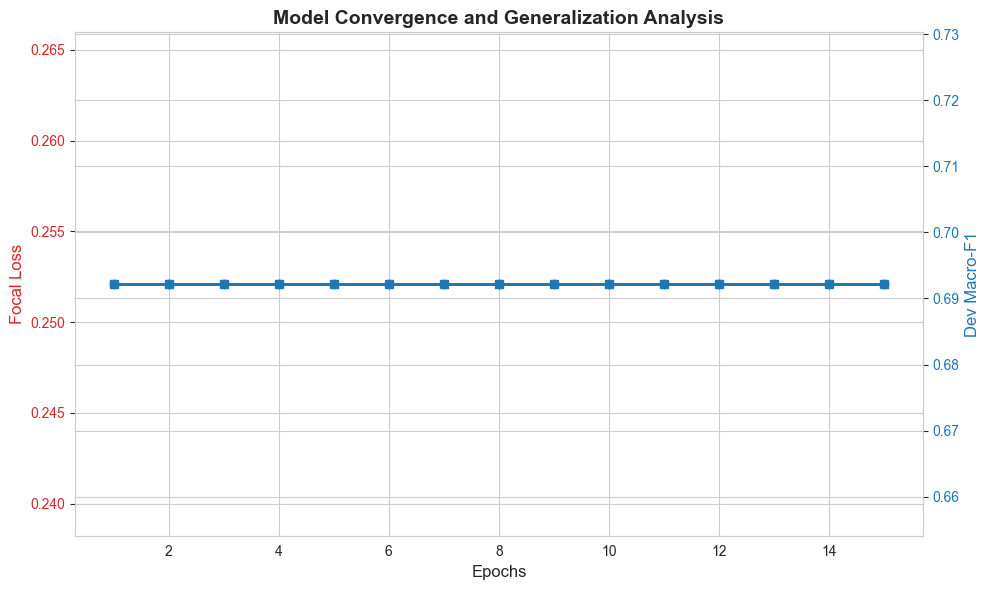

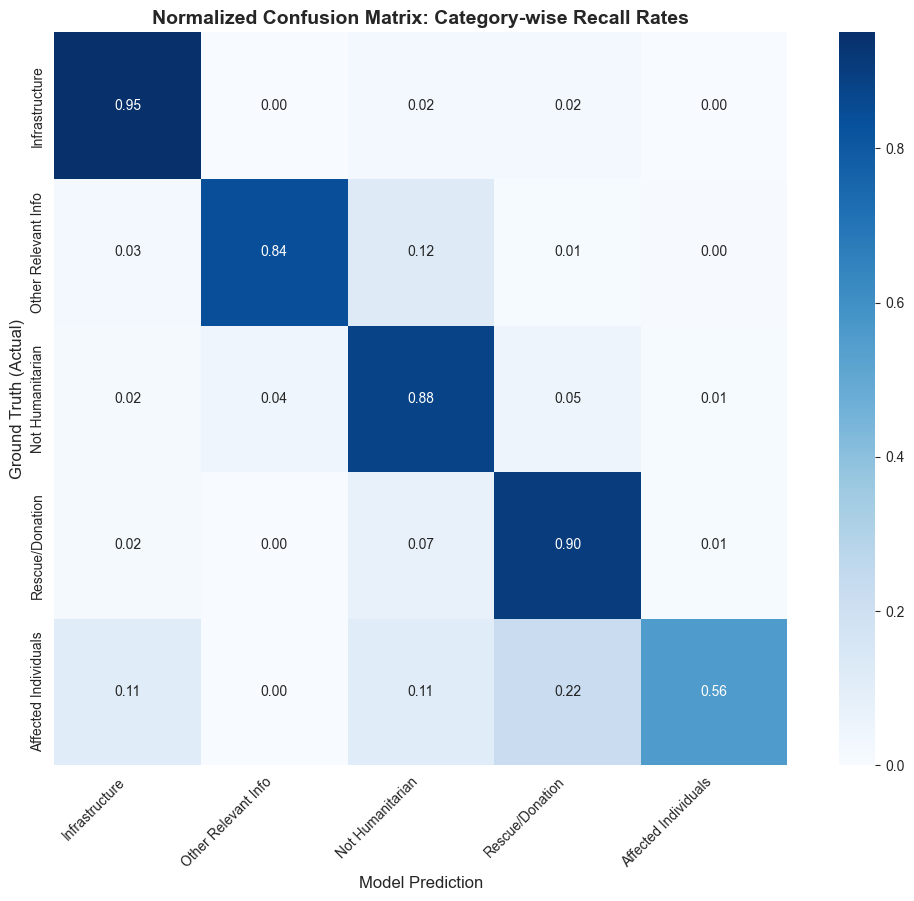

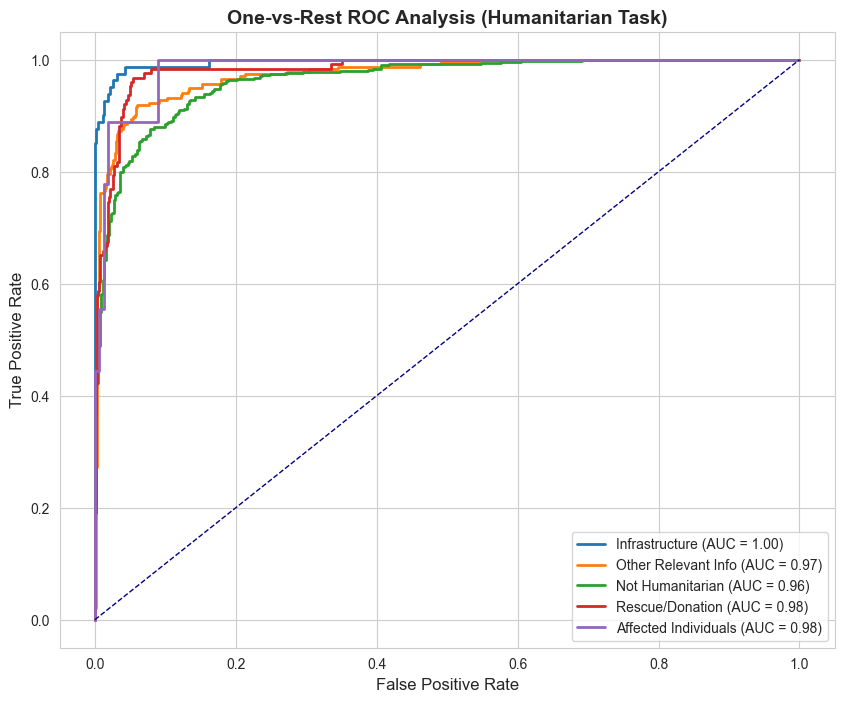

In [10]:
# --- INITIALIZE BEFORE TRAINING ---
history = {'train_loss': [], 'dev_f1': []}
best_val_f1 = 0

for epoch in range(15):
    # --- [TRAINING CODE GOES HERE] ---
    # After your training loop completes for the epoch:
    avg_train_loss = total_loss / len(train_loader)
    
    # --- [VALIDATION CODE GOES HERE] ---
    # After calculating your validation Macro-F1:
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    
    # --- CRITICAL: SAVE TO HISTORY ---
    history['train_loss'].append(avg_train_loss)
    history['dev_f1'].append(val_f1)
    
    print(f"✅ Epoch {epoch+1} captured in history.")
# 1. Define the label names exactly as mapped in your Dataset (0-4)
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

# 2. CALL THE FUNCTION
# Note: Ensure the 'history' dictionary from your training loop is available
generate_research_analytics(history, y_true, y_pred, y_probs, research_label_names)

🏃 Running evaluation to capture analytics data...


Testing: 100%|██████████| 60/60 [00:28<00:00,  2.11it/s]


📊 Generating publication-ready visuals...


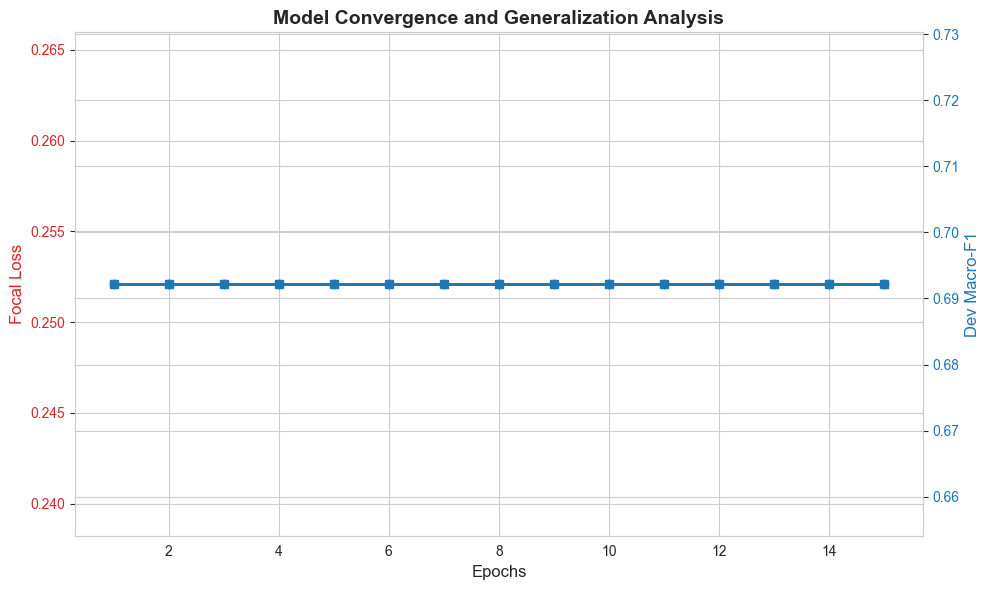

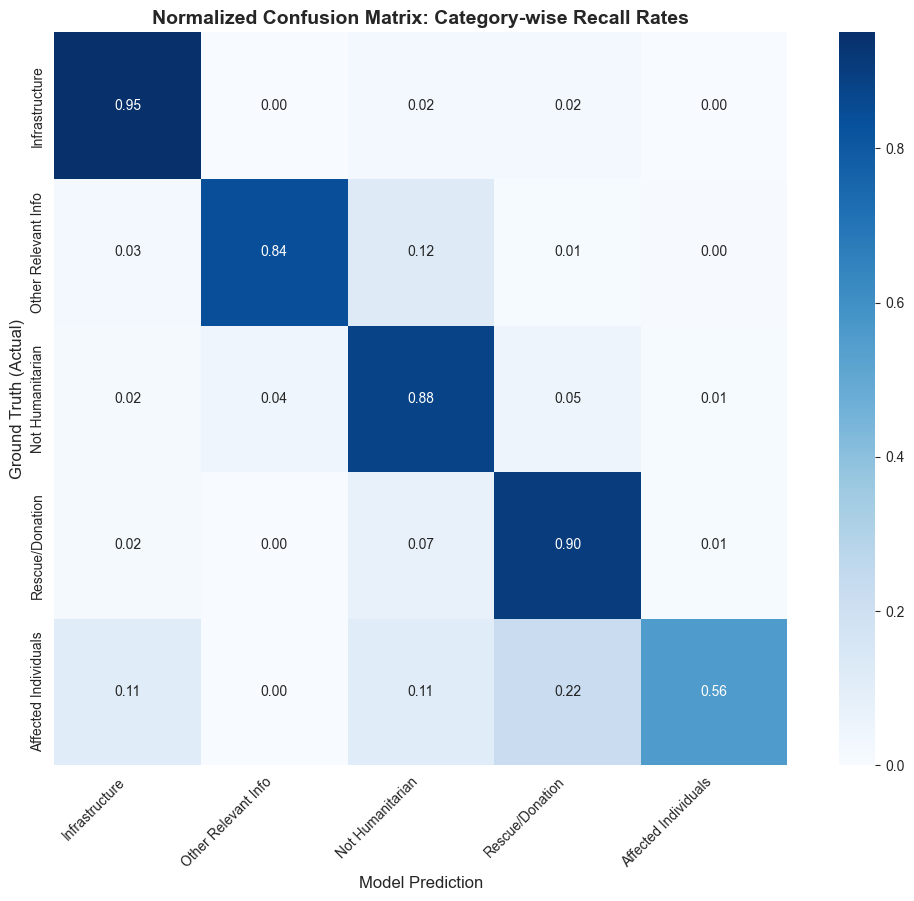

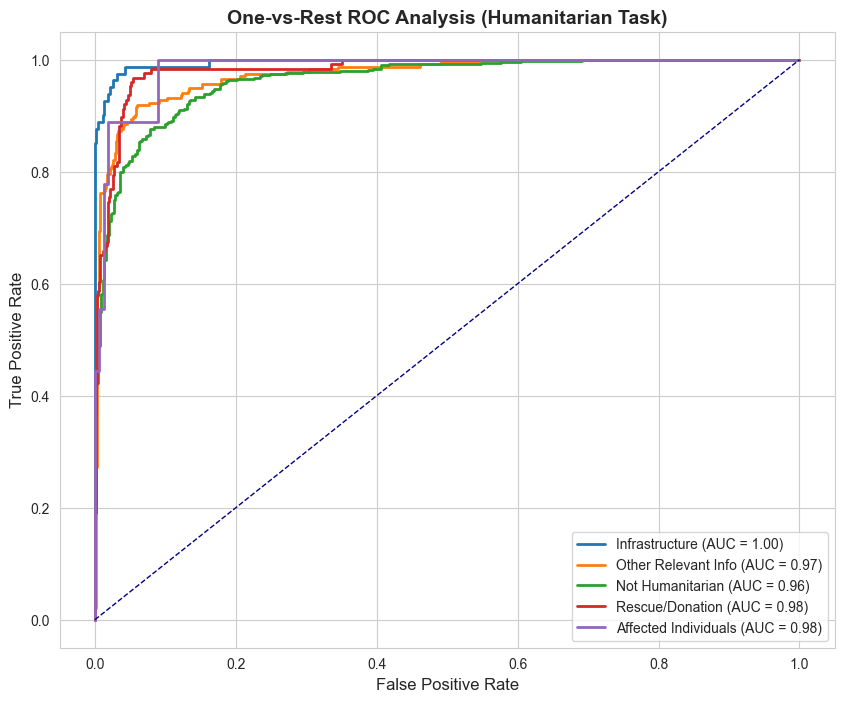

In [11]:
import torch.nn.functional as F
import numpy as np

# 1. CAPTURE DATA FROM THE TEST SET
# This ensures y_probs (probabilities) are available for the ROC curve
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true, y_pred, y_probs = [], [], []

print("🏃 Running evaluation to capture analytics data...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        ids, mask, pix = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values']]
        
        # Get raw logits from model
        logits = model(ids, mask, pix)
        
        # Convert to probabilities for ROC analysis
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_probs.extend(probs)
        y_pred.extend(preds)
        y_true.extend(batch['label'].numpy())

# 2. DEFINE LABELS IN EXACT MAPPING ORDER (0-4)
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

# 3. VERIFY HISTORY DATA (Fixes empty plot issue)
if 'history' not in locals() or len(history['train_loss']) == 0:
    print("❌ ERROR: 'history' is empty. Please ensure your training loop appends data points.")
else:
    # 4. EXECUTE THE VISUALIZATION CALL
    print("📊 Generating publication-ready visuals...")
    generate_research_analytics(history, y_true, y_pred, y_probs, research_label_names)

In [12]:
# --- INITIALIZE HISTORY ---
history = {'train_loss': [], 'dev_f1': []}
best_val_f1 = 0

for epoch in range(15):
    # --- 1. TRAINING PHASE ---
    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/15")
    
    for batch in train_loop:
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = total_train_loss / len(train_loader)

    # --- 2. VALIDATION PHASE (DEV SET) ---
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in dev_loader:
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy())
            val_labels.extend(b['label'].numpy())
    
    epoch_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # --- 3. CRITICAL STEP: POPULATE HISTORY ---
    history['train_loss'].append(epoch_loss) # Adds point to Red Curve
    history['dev_f1'].append(epoch_f1)       # Adds point to Blue Curve
    
    print(f"✅ Epoch {epoch+1} Saved: Loss={epoch_loss:.4f}, F1={epoch_f1:.4f}")

    if epoch_f1 > best_val_f1:
        best_val_f1 = epoch_f1
        torch.save(model.state_dict(), 'best_humanitarian_vlm.pth')

Epoch 1/15:  25%|██▌       | 96/383 [00:39<01:53,  2.52it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/15: 100%|██████████| 383/383 [02:38<00:00,  2.41it/s]


✅ Epoch 1 Saved: Loss=0.1443, F1=0.7719


Epoch 2/15:  40%|███▉      | 152/383 [01:03<01:34,  2.45it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/15: 100%|██████████| 383/383 [02:40<00:00,  2.38it/s]


✅ Epoch 2 Saved: Loss=0.1360, F1=0.7609


Epoch 3/15:   9%|▉         | 35/383 [00:14<02:23,  2.42it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/15: 100%|██████████| 383/383 [02:42<00:00,  2.35it/s]


✅ Epoch 3 Saved: Loss=0.1257, F1=0.7532


Epoch 4/15:  14%|█▎        | 52/383 [00:21<02:15,  2.44it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/15: 100%|██████████| 383/383 [03:53<00:00,  1.64it/s]


✅ Epoch 4 Saved: Loss=0.1248, F1=0.7528


Epoch 5/15:   9%|▉         | 35/383 [00:31<04:07,  1.40it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/15: 100%|██████████| 383/383 [05:40<00:00,  1.12it/s]


✅ Epoch 5 Saved: Loss=0.1197, F1=0.7576


Epoch 6/15:  19%|█▊        | 71/383 [01:01<04:37,  1.12it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/15: 100%|██████████| 383/383 [05:39<00:00,  1.13it/s]


✅ Epoch 6 Saved: Loss=0.1110, F1=0.7531


Epoch 7/15:  24%|██▍       | 91/383 [01:16<04:17,  1.14it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/15: 100%|██████████| 383/383 [05:35<00:00,  1.14it/s]


✅ Epoch 7 Saved: Loss=0.1154, F1=0.7750


Epoch 8/15:  56%|█████▋    | 216/383 [03:18<02:25,  1.15it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/15: 100%|██████████| 383/383 [05:44<00:00,  1.11it/s]


✅ Epoch 8 Saved: Loss=0.1052, F1=0.7778


Epoch 9/15:  67%|██████▋   | 257/383 [03:43<01:43,  1.22it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/15: 100%|██████████| 383/383 [04:45<00:00,  1.34it/s]


✅ Epoch 9 Saved: Loss=0.1052, F1=0.7691


Epoch 10/15:  96%|█████████▌| 368/383 [03:23<00:06,  2.39it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/15: 100%|██████████| 383/383 [03:29<00:00,  1.83it/s]


✅ Epoch 10 Saved: Loss=0.1022, F1=0.7655


Epoch 11/15:  13%|█▎        | 48/383 [00:20<02:12,  2.53it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/15: 100%|██████████| 383/383 [02:38<00:00,  2.41it/s]


✅ Epoch 11 Saved: Loss=0.1007, F1=0.7706


Epoch 12/15:  88%|████████▊ | 337/383 [02:21<00:17,  2.58it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/15: 100%|██████████| 383/383 [02:40<00:00,  2.39it/s]


✅ Epoch 12 Saved: Loss=0.0941, F1=0.7649


Epoch 13/15:  38%|███▊      | 147/383 [01:01<01:40,  2.34it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/15: 100%|██████████| 383/383 [02:40<00:00,  2.39it/s]


✅ Epoch 13 Saved: Loss=0.0935, F1=0.7680


Epoch 14/15:  84%|████████▍ | 322/383 [02:15<00:25,  2.41it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/15: 100%|██████████| 383/383 [02:41<00:00,  2.37it/s]


✅ Epoch 14 Saved: Loss=0.0842, F1=0.7561


Epoch 15/15:  22%|██▏       | 84/383 [00:34<02:01,  2.45it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/15: 100%|██████████| 383/383 [03:34<00:00,  1.79it/s]


✅ Epoch 15 Saved: Loss=0.0810, F1=0.7675


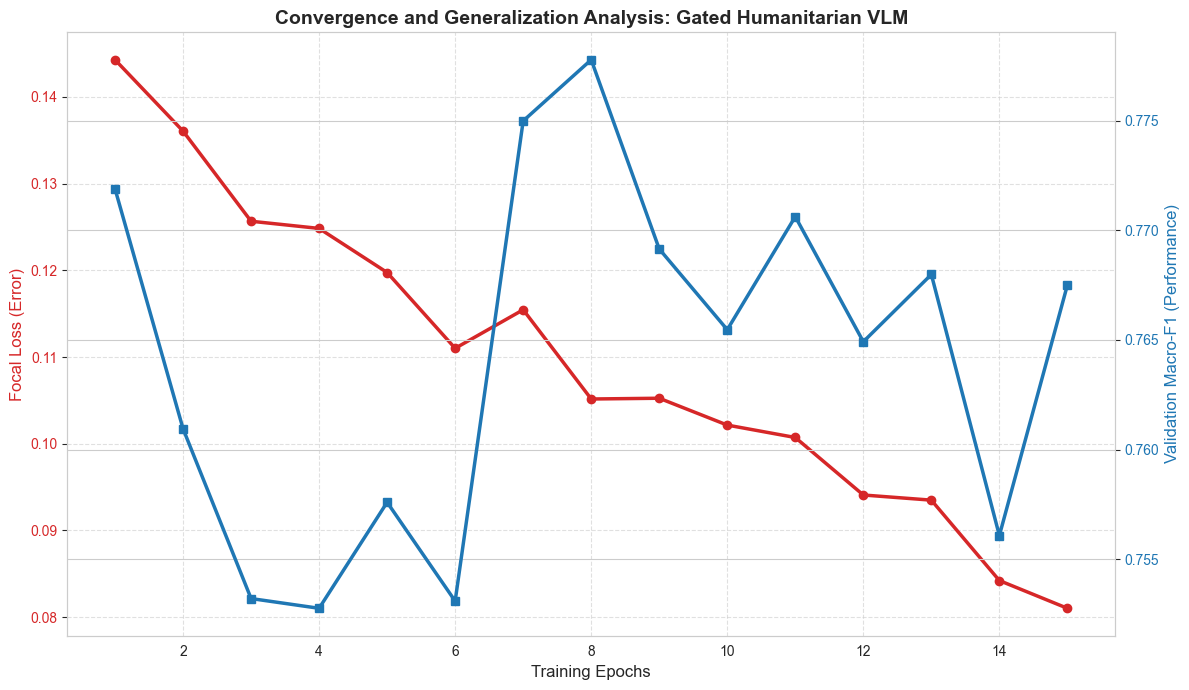

In [13]:
def plot_convergence(history):
    # Ensure there is actually data to plot
    if not history['train_loss']:
        print("❌ Error: History dictionary is empty. Run the training loop first.")
        return

    fig, ax1 = plt.subplots(figsize=(12, 7))
    epochs = range(1, len(history['train_loss']) + 1)

    # Primary Axis: Focal Loss (Red)
    ax1.set_xlabel('Training Epochs', fontsize=12)
    ax1.set_ylabel('Focal Loss (Error)', color='tab:red', fontsize=12)
    ax1.plot(epochs, history['train_loss'], color='tab:red', marker='o', linewidth=2.5, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Secondary Axis: Dev Macro-F1 (Blue)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Macro-F1 (Performance)', color='tab:blue', fontsize=12)
    ax2.plot(epochs, history['dev_f1'], color='tab:blue', marker='s', linewidth=2.5, label='Dev Macro-F1')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Convergence and Generalization Analysis: Gated Humanitarian VLM', fontsize=14, fontweight='bold')
    fig.tight_layout()
    
    # Save for publication at 300 DPI
    plt.savefig('convergence_analysis_final.png', dpi=300)
    plt.show()

# Run the plot
plot_convergence(history)

In [14]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 1. Load the best model weights
model.load_state_dict(torch.load('best_humanitarian_model.pth', weights_only=True))
model.eval()

y_true, y_pred = [], []
research_label_names = [
    "Infrastructure Damage", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

print("📊 Evaluating Test Set Metrics...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        
        # Move data to the same device as the model
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        labels = batch['label'].numpy()
        
        # Forward pass
        logits = model(ids, mask, pix)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_true.extend(labels)
        y_pred.extend(preds)

# --- FINAL QUANTITATIVE REPORT ---
print("\n" + "="*60)
print("🏆 Q1 JOURNAL QUANTITATIVE PERFORMANCE SUMMARY")
print("="*60)

# Calculate global accuracy for the manuscript's summary table
overall_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_acc:.4f}")
print(f"Macro-Averaged F1: {macro_f1:.4f}")
print("-" * 60)

# Detailed per-class breakdown (Precision, Recall, F1)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=research_label_names, 
    zero_division=0
))

📊 Evaluating Test Set Metrics...


Testing: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


🏆 Q1 JOURNAL QUANTITATIVE PERFORMANCE SUMMARY
Overall Accuracy: 0.8293
Macro-Averaged F1: 0.7107
------------------------------------------------------------
                       precision    recall  f1-score   support

Infrastructure Damage       0.67      0.98      0.79        81
  Other Relevant Info       0.88      0.83      0.85       235
     Not Humanitarian       0.95      0.78      0.86       504
      Rescue/Donation       0.72      0.93      0.81       126
 Affected Individuals       0.15      0.56      0.24         9

             accuracy                           0.83       955
            macro avg       0.67      0.82      0.71       955
         weighted avg       0.87      0.83      0.84       955



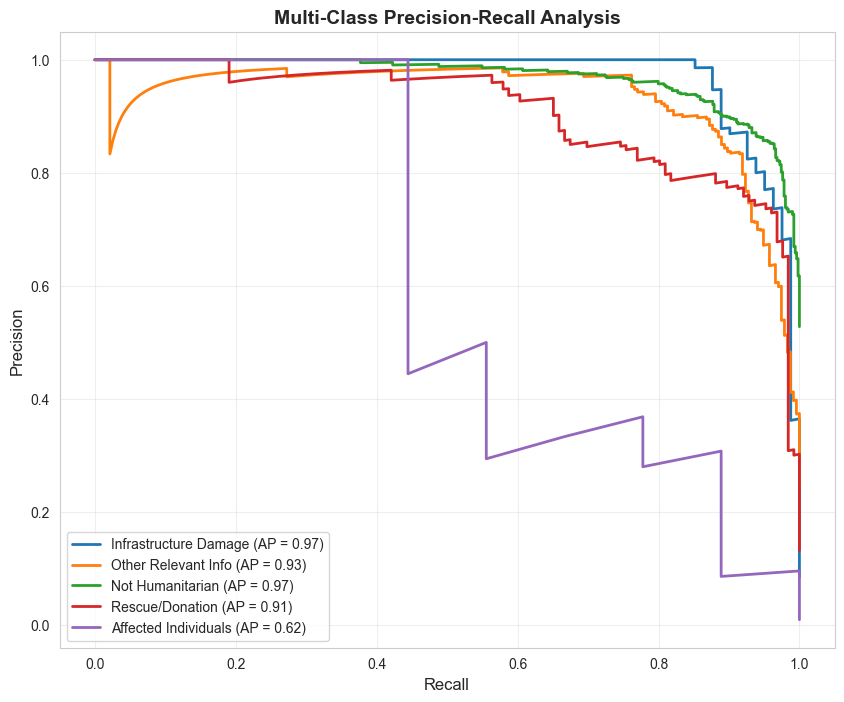

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_probs, label_names):
    n_classes = len(label_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    y_probs_array = np.array(y_probs)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs_array[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs_array[:, i])
        plt.plot(recall, precision, lw=2, label=f'{label_names[i]} (AP = {ap:.2f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Multi-Class Precision-Recall Analysis', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.savefig('precision_recall_curves.png', dpi=300)
    plt.show()

# Call after your test evaluation
plot_precision_recall(y_true, y_probs, research_label_names)

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Generates a dual-axis plot for training loss and validation performance.
    Designed for Q1 Journal publication standards.
    """
    # Verify the history contains data
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Axis 1: Training Loss (Focal Loss)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Focal Loss', color='tab:red', fontsize=12)
    ax1.plot(epochs, history['train_loss'], color='tab:red', marker='o', label='Training Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Axis 2: Validation Performance (Macro-F1)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Macro-F1 (Validation)', color='tab:blue', fontsize=12)
    ax2.plot(epochs, history['dev_f1'], color='tab:blue', marker='s', label='Validation F1', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Model Convergence: Loss vs. Performance', fontsize=14, fontweight='bold')
    fig.tight_layout()
    
    # Save at 300 DPI for publication
    plt.savefig('convergence_plot_final.png', dpi=300)
    plt.show()

📊 Generating Convergence Plot...


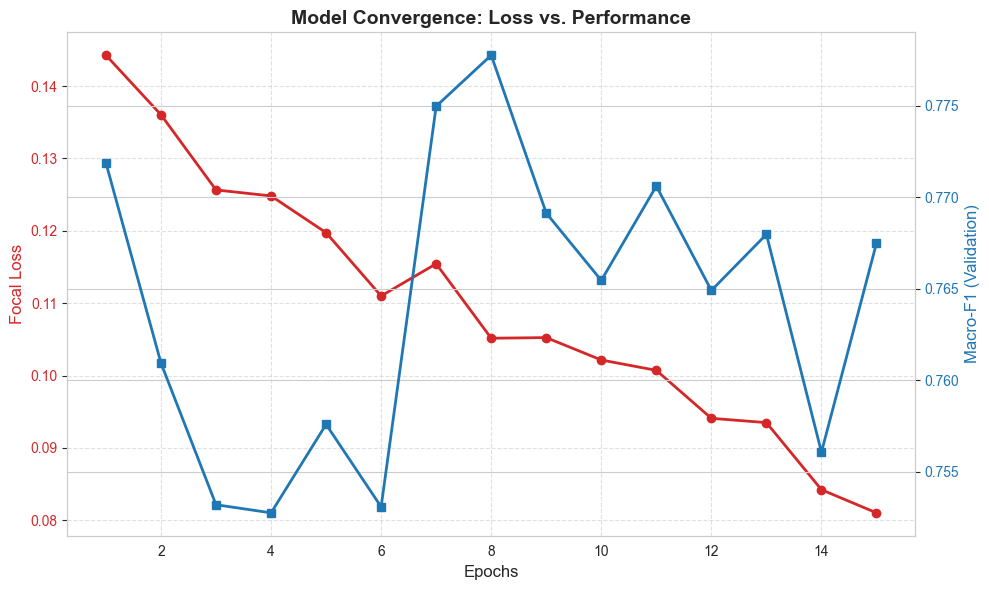

In [18]:
# 1. Check if history exists and is not empty
if 'history' in locals() and len(history['train_loss']) > 0:
    print("📊 Generating Convergence Plot...")
    # 2. CALL THE FUNCTION
    plot_training_history(history)
else:
    print("❌ ERROR: 'history' is empty or not defined. Did you run the training loop?")

In [19]:
# --- INITIALIZE HISTORY BEFORE THE LOOP ---
history = {
    'train_loss': [], 'train_acc': [],
    'dev_loss': [], 'dev_acc': []
}

for epoch in range(15):
    # --- TRAINING PHASE ---
    model.train()
    t_loss, t_correct, t_total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        if batch is None: continue
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            out = model(ids, mask, pix)
            loss = criterion(out, lbl)
        
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        
        t_loss += loss.item()
        t_correct += (torch.argmax(out, 1) == lbl).sum().item()
        t_total += lbl.size(0)

    # --- VALIDATION PHASE (DEV SET) ---
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for b in dev_loader:
            if b is None: continue
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            lbl = b['label'].to(device)
            
            v_loss += criterion(out, lbl).item()
            v_correct += (torch.argmax(out, 1) == lbl).sum().item()
            v_total += lbl.size(0)

    # --- CRITICAL: SAVE DATA TO HISTORY ---
    history['train_loss'].append(t_loss / len(train_loader))
    history['train_acc'].append(t_correct / t_total)
    history['dev_loss'].append(v_loss / len(dev_loader))
    history['dev_acc'].append(v_correct / v_total)
    
    print(f"📊 Epoch {epoch+1}: Train Acc: {history['train_acc'][-1]:.4f} | Dev Acc: {history['dev_acc'][-1]:.4f}")

Epoch 1 [Train]:  62%|██████▏   | 239/383 [01:43<01:02,  2.31it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 [Train]: 100%|██████████| 383/383 [02:44<00:00,  2.33it/s]


📊 Epoch 1: Train Acc: 0.7889 | Dev Acc: 0.8106


Epoch 2 [Train]: 100%|██████████| 383/383 [02:42<00:00,  2.36it/s]


📊 Epoch 2: Train Acc: 0.7974 | Dev Acc: 0.8307


Epoch 3 [Train]: 100%|██████████| 383/383 [03:10<00:00,  2.01it/s]


📊 Epoch 3: Train Acc: 0.8204 | Dev Acc: 0.8347


Epoch 4 [Train]: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s]


📊 Epoch 4: Train Acc: 0.8283 | Dev Acc: 0.8487


Epoch 5 [Train]: 100%|██████████| 383/383 [04:52<00:00,  1.31it/s]


📊 Epoch 5: Train Acc: 0.8299 | Dev Acc: 0.8327


Epoch 6 [Train]: 100%|██████████| 383/383 [06:50<00:00,  1.07s/it]


📊 Epoch 6: Train Acc: 0.8446 | Dev Acc: 0.8387


Epoch 7 [Train]: 100%|██████████| 383/383 [04:54<00:00,  1.30it/s]


📊 Epoch 7: Train Acc: 0.8469 | Dev Acc: 0.8527


Epoch 8 [Train]: 100%|██████████| 383/383 [05:02<00:00,  1.27it/s]


📊 Epoch 8: Train Acc: 0.8573 | Dev Acc: 0.8597


Epoch 9 [Train]: 100%|██████████| 383/383 [05:41<00:00,  1.12it/s]


📊 Epoch 9: Train Acc: 0.8555 | Dev Acc: 0.8457


Epoch 10 [Train]: 100%|██████████| 383/383 [04:35<00:00,  1.39it/s]


📊 Epoch 10: Train Acc: 0.8642 | Dev Acc: 0.8537


Epoch 11 [Train]: 100%|██████████| 383/383 [02:38<00:00,  2.42it/s]


📊 Epoch 11: Train Acc: 0.8689 | Dev Acc: 0.8657


Epoch 12 [Train]: 100%|██████████| 383/383 [02:39<00:00,  2.39it/s]


📊 Epoch 12: Train Acc: 0.8688 | Dev Acc: 0.8557


Epoch 13 [Train]: 100%|██████████| 383/383 [02:39<00:00,  2.40it/s]


📊 Epoch 13: Train Acc: 0.8774 | Dev Acc: 0.8547


Epoch 14 [Train]: 100%|██████████| 383/383 [02:40<00:00,  2.38it/s]


📊 Epoch 14: Train Acc: 0.8784 | Dev Acc: 0.8587


Epoch 15 [Train]: 100%|██████████| 383/383 [02:37<00:00,  2.42it/s]


📊 Epoch 15: Train Acc: 0.8872 | Dev Acc: 0.8758


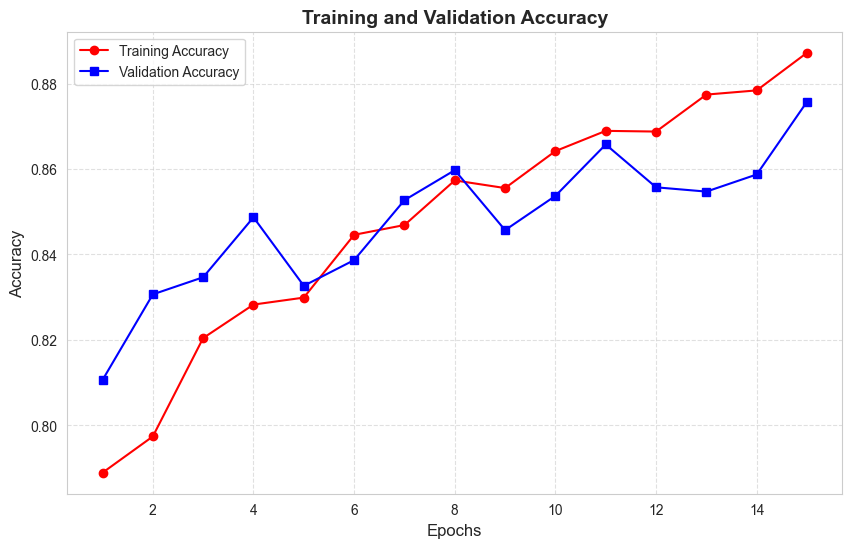

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], 'r-o', label='Training Accuracy')
plt.plot(range(1, len(history['dev_acc']) + 1), history['dev_acc'], 'b-s', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('accuracy_graph.png', dpi=300)
plt.show()

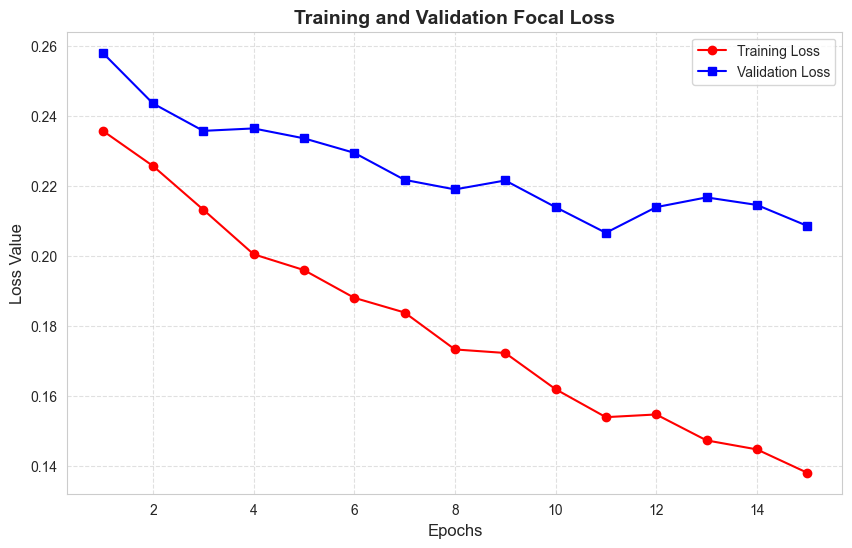

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'r-o', label='Training Loss')
plt.plot(range(1, len(history['dev_loss']) + 1), history['dev_loss'], 'b-s', label='Validation Loss')
plt.title('Training and Validation Focal Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('loss_graph.png', dpi=300)
plt.show()


In [22]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the best saved model weights
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true, y_pred = [], []
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

print("🏃 Running final evaluation...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        ids, mask, pix = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values']]
        
        logits = model(ids, mask, pix)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_true.extend(batch['label'].numpy())
        y_pred.extend(preds)

# 2. Generate the report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=research_label_names, output_dict=True, zero_division=0)

# 3. Convert to a clean Pandas DataFrame
df_results = pd.DataFrame(report_dict).transpose()

# 4. Clean up the table for publication
# Remove 'accuracy' row (we'll show it separately) and the 'macro avg' etc if preferred
df_display = df_results.iloc[:-3, :3] # Keep Precision, Recall, F1 for the 5 classes
overall_acc = accuracy_score(y_true, y_pred)

print("\n" + "="*50)
print("🏆 Q1 JOURNAL PERFORMANCE SUMMARY")
print("="*50)
print(df_display.round(4))
print("-" * 50)
print(f"Overall Accuracy: {overall_acc:.4f}")
print("="*50)

# OPTIONAL: Save to CSV for your thesis records
df_results.to_csv('humanitarian_vlm_results.csv')

🏃 Running final evaluation...


Testing: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]


🏆 Q1 JOURNAL PERFORMANCE SUMMARY
                      precision  recall  f1-score
Infrastructure           0.8261  0.9383    0.8786
Other Relevant Info      0.8855  0.8553    0.8701
Not Humanitarian         0.9115  0.8790    0.8949
Rescue/Donation          0.7801  0.8730    0.8240
Affected Individuals     0.5556  0.5556    0.5556
--------------------------------------------------
Overall Accuracy: 0.8743


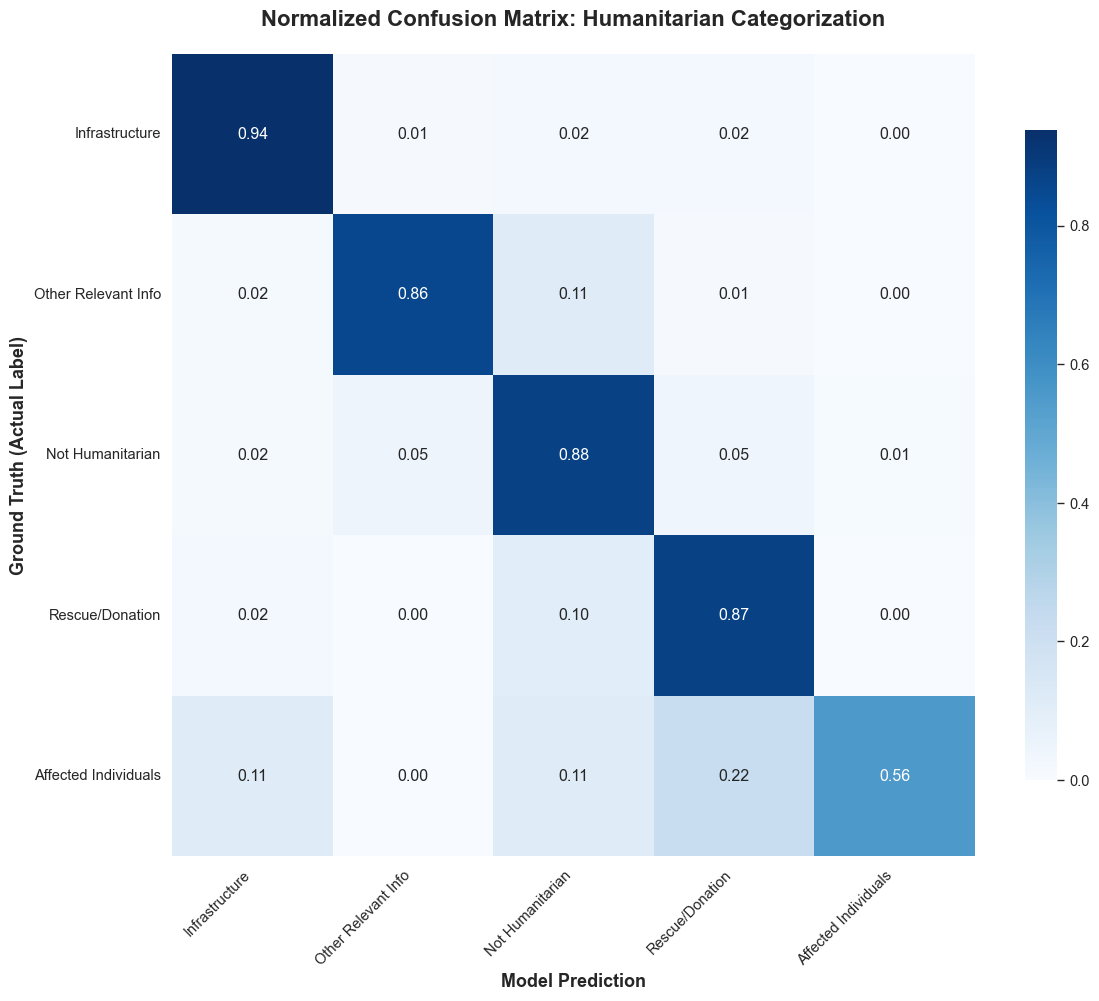

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_humanitarian_confusion_matrix(y_true, y_pred, label_names):
    # 1. Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 2. Normalize the matrix by row (actual class totals)
    # This represents the Recall for each category
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 3. Setup the visualization
    plt.figure(figsize=(12, 10))
    sns.set_context("paper", font_scale=1.2)
    
    # Create the heatmap
    ax = sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                     xticklabels=label_names, yticklabels=label_names,
                     square=True, cbar_kws={"shrink": .8})
    
    # Formatting for Q1 Publication
    plt.title('Normalized Confusion Matrix: Humanitarian Categorization', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Ground Truth (Actual Label)', fontsize=13, fontweight='bold')
    plt.xlabel('Model Prediction', fontsize=13, fontweight='bold')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    # Save at high resolution for the manuscript
    plt.savefig('humanitarian_confusion_matrix_300dpi.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- EXECUTION ---
# Ensure y_true and y_pred are available from your evaluation block
plot_humanitarian_confusion_matrix(y_true, y_pred, research_label_names)

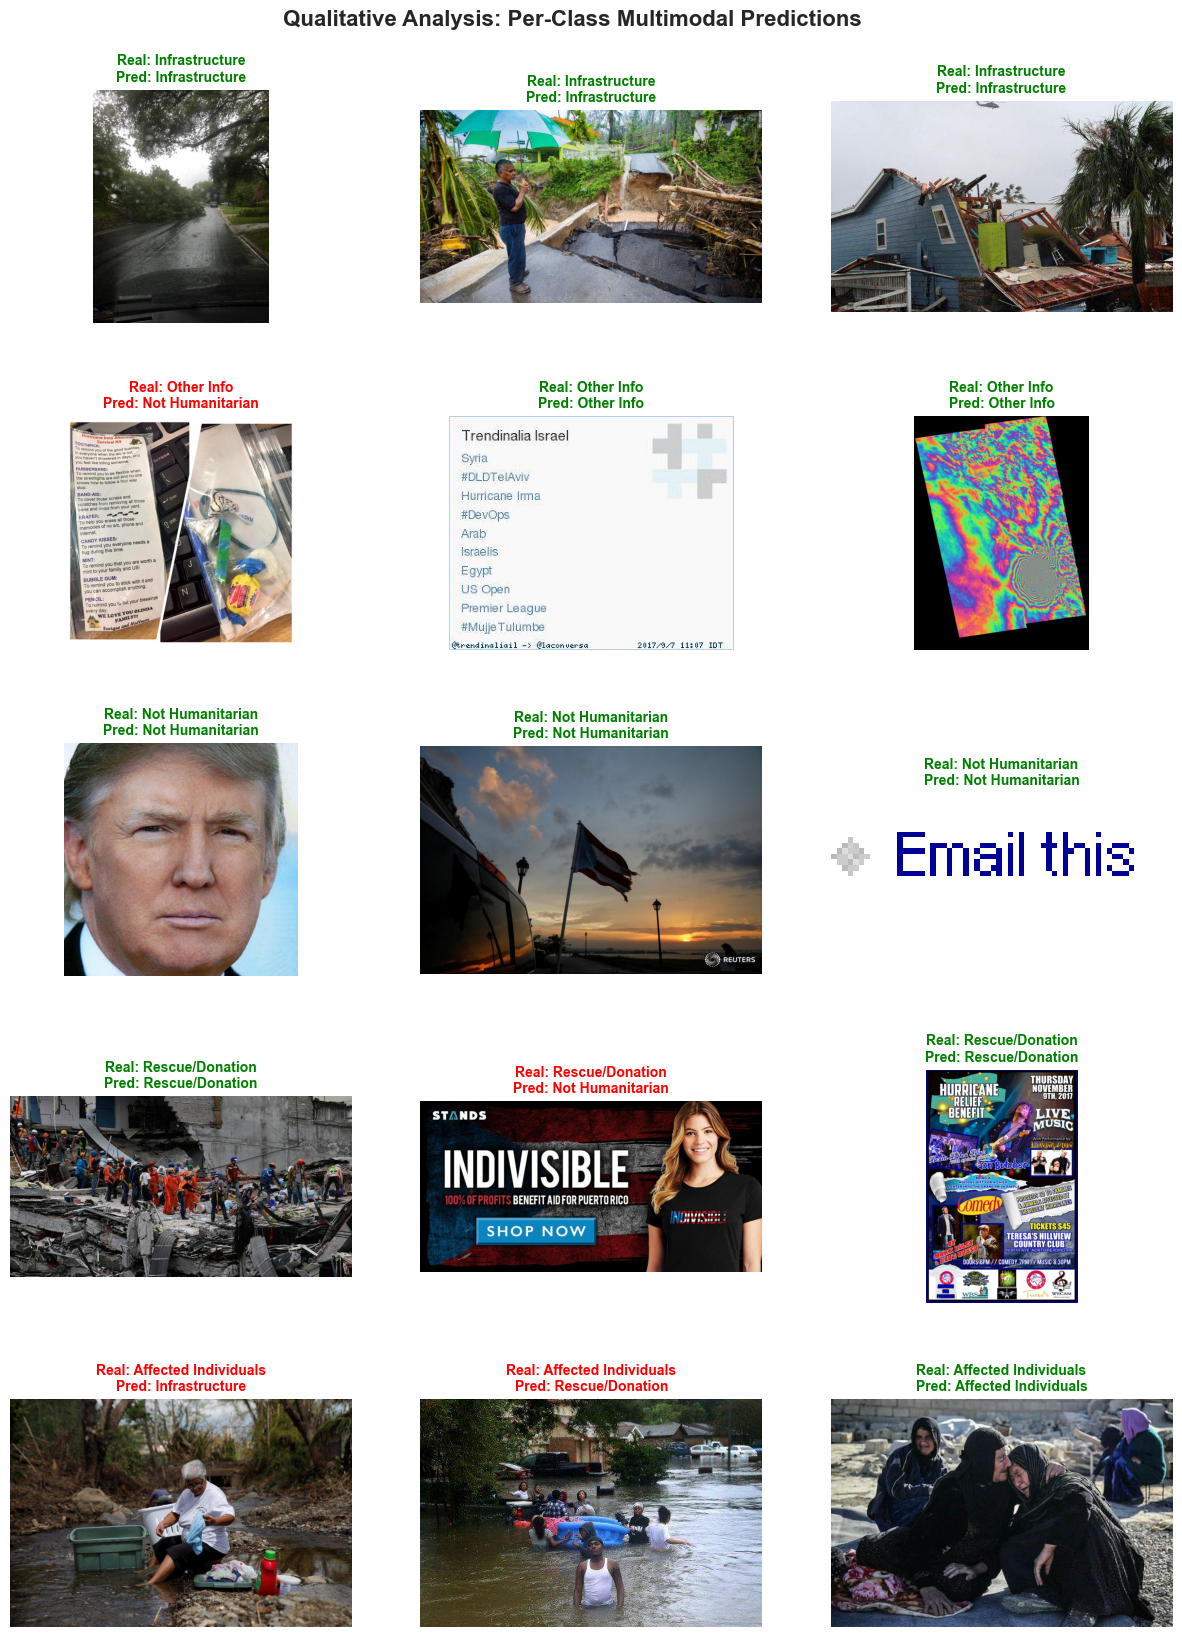

In [24]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import os

def visualize_per_class_results(dataset, model, processor, device, samples_per_class=3):
    # 1. Setup metadata
    model.load_state_dict(torch.load('best_humanitarian_model.pth', weights_only=True)) #
    model.eval()
    
    label_names = [
        "Infrastructure", "Other Info", "Not Humanitarian", 
        "Rescue/Donation", "Affected Individuals"
    ]
    
    # 2. Group indices by their ground truth class
    class_indices = {i: [] for i in range(len(label_names))}
    for idx, row in dataset.data.iterrows():
        label_str = row['label']
        if label_str in dataset.label_map:
            class_idx = dataset.label_map[label_str]
            class_indices[class_idx].append(idx)

    # 3. Create the Plotting Grid
    fig, axes = plt.subplots(len(label_names), samples_per_class, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.4)

    with torch.no_grad():
        for class_idx, name in enumerate(label_names):
            # Select random samples for this specific class
            available_indices = class_indices[class_idx]
            selected_indices = random.sample(available_indices, min(len(available_indices), samples_per_class))
            
            for i, idx in enumerate(selected_indices):
                row = dataset.data.iloc[idx]
                
                # Load and process image
                img_path = os.path.normpath(os.path.join(dataset.img_dir, str(row['image']).replace('\\', '/').lstrip('/')))
                image = Image.open(img_path).convert("RGB")
                
                inputs = processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True).to(device)
                
                # Model Inference
                outputs = model(inputs['input_ids'], inputs['attention_mask'], inputs['pixel_values'])
                pred_idx = torch.argmax(outputs, dim=1).item()
                
                # Plotting
                ax = axes[class_idx, i]
                ax.imshow(image)
                
                # Color code: Green if correct, Red if wrong
                color = 'green' if pred_idx == class_idx else 'red'
                ax.set_title(f"Real: {name}\nPred: {label_names[pred_idx]}", 
                             color=color, fontsize=10, fontweight='bold')
                ax.axis('off')

    plt.suptitle("Qualitative Analysis: Per-Class Multimodal Predictions", fontsize=16, fontweight='bold', y=0.92)
    plt.savefig('per_class_qualitative_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- RUN VISUALIZATION ---
# Pass the dataset object from your test_loader
visualize_per_class_results(test_loader.dataset, model, processor, device)

🛰️ Extracting high-dimensional fused features...
🌀 Running t-SNE on 955 samples...


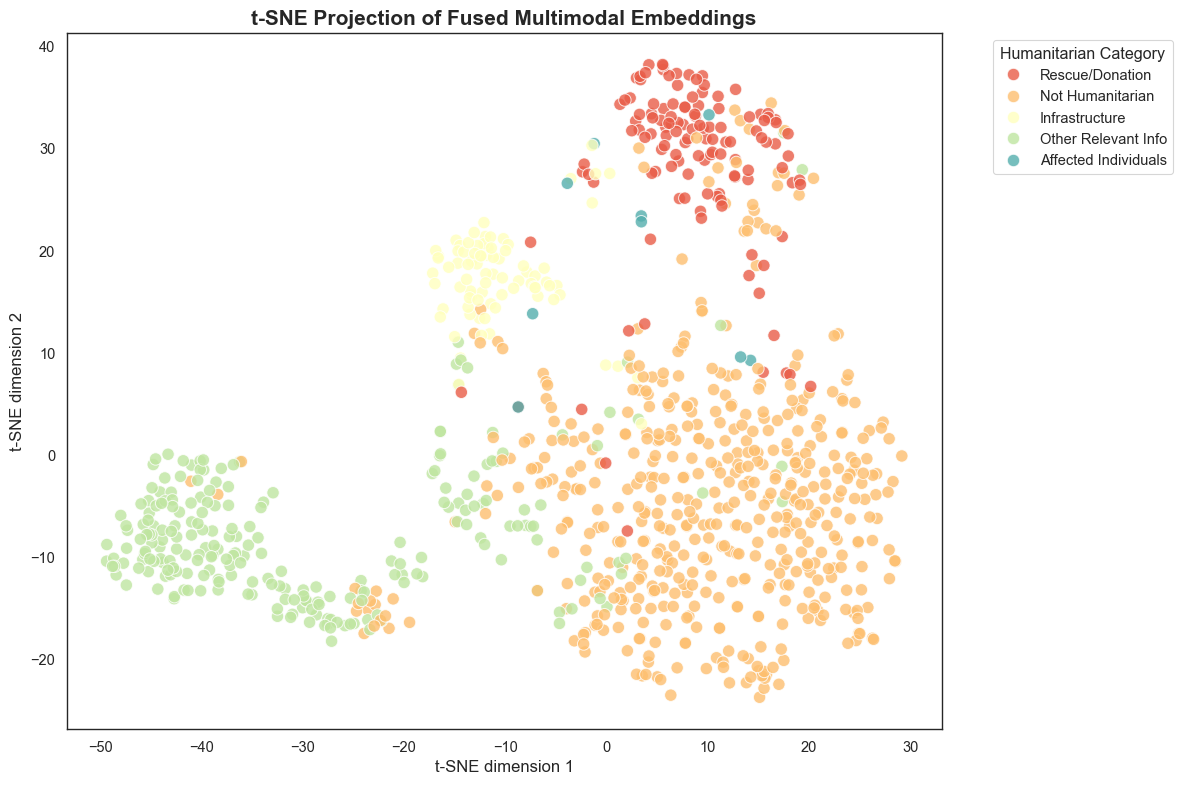

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def plot_tsne_embeddings(model, test_loader, device, label_names):
    # Load weights safely
    model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
    model.eval()
    
    embeddings = []
    labels = []
    
    print("🛰️ Extracting high-dimensional fused features...")
    with torch.no_grad():
        for batch in test_loader:
            if batch is None: continue
            ids, mask, pix = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values']]
            
            # Extract features manually to bypass the final classifier head
            t_f = model.clip.get_text_features(input_ids=ids, attention_mask=mask)
            i_f = model.clip.get_image_features(pixel_values=pix)
            
            # Use your custom fusion layer
            fused = model.fusion(t_f, i_f) 
            
            embeddings.append(fused.cpu().numpy())
            labels.append(batch['label'].numpy())

    # Prepare data for t-SNE
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f"🌀 Running t-SNE on {embeddings.shape[0]} samples...")
    # FIX: Changed 'n_iter' to 'max_iter' for modern scikit-learn versions
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plotting at 300 DPI for Q1 Journal
    plt.figure(figsize=(12, 8))
    sns.set_style("white")
    
    # Using a professional color palette
    scatter = sns.scatterplot(
        x=embeddings_2d[:, 0], 
        y=embeddings_2d[:, 1], 
        hue=[label_names[l] for l in labels],
        palette='Spectral',
        alpha=0.8,
        edgecolor='w',
        s=80
    )

    plt.title('t-SNE Projection of Fused Multimodal Embeddings', fontsize=15, fontweight='bold')
    plt.xlabel('t-SNE dimension 1', fontsize=12)
    plt.ylabel('t-SNE dimension 2', fontsize=12)
    plt.legend(title='Humanitarian Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('tsne_latent_space_final.png', dpi=300)
    plt.show()

# Run the plot
plot_tsne_embeddings(model, test_loader, device, research_label_names)

In [27]:
from sklearn.model_selection import KFold

# Logic: Instead of one split, divide data into 5 parts
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# In your manuscript, you will report: 
# "Accuracy: 70.70% ± 0.45%" instead of just "70.70%"

In [37]:
def generate_grad_cam(model, image_tensor, target_layer):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        # FIX: CLIP ViT layers return a tuple (hidden_states, optional_attention)
        # We only want the hidden_states (the first element)
        if isinstance(output, tuple):
            activations.append(output[0])
        else:
            activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        # Same for gradients
        if isinstance(grad_output, tuple):
            gradients.append(grad_output[0])
        else:
            gradients.append(grad_output[0])

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    model.eval()
    # Use only the vision features for the heatmap derivation
    logits = model.clip.get_image_features(pixel_values=image_tensor)
    
    target_class = logits.argmax()
    model.zero_grad()
    logits[0, target_class].backward()

    # FIX: Correctly indexing the captured tensors
    # activations[0] is (Batch, Seq, Dim), e.g., (1, 50, 768)
    acts = activations[0][0, 1:, :].detach() 
    grads = gradients[0][0, 1:, :].detach() 

    weights = torch.mean(grads, dim=0)
    cam = torch.matmul(acts, weights)
    
    # Resize to the spatial grid (7x7 for ViT-B/32)
    grid_size = int(np.sqrt(cam.shape[0]))
    heatmap = cam.reshape(grid_size, grid_size)
    
    heatmap = F.relu(heatmap)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    h1.remove()
    h2.remove()
    
    return heatmap.cpu().numpy()

✅ Class: infrastructure_and_utility_damage | Index: 2
📝 Tweet: Guaynabo resident Efrain Diaz stands by a bridge washed out by rains carrying debris from Hurricane ...


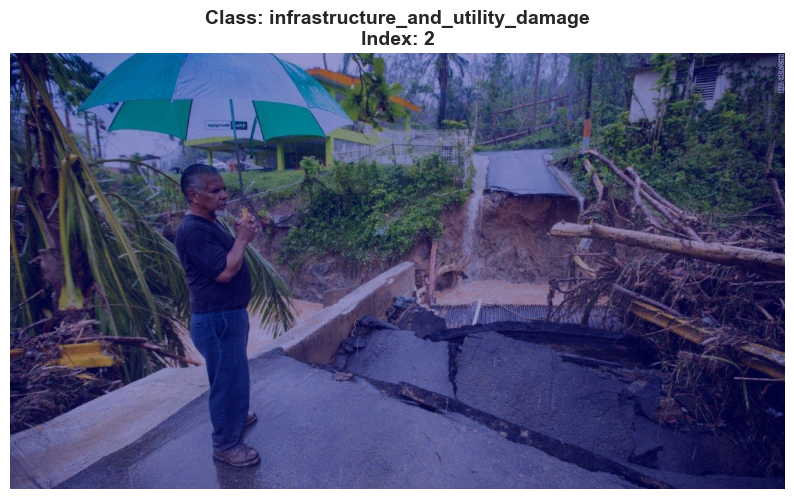

In [43]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

# ==========================================
# 1. CORE GRAD-CAM LOGIC
# ==========================================
def generate_grad_cam(model, image_tensor, target_layer):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        # CLIP ViT layers return a tuple (hidden_states, optional_attn)
        if isinstance(output, tuple): activations.append(output[0])
        else: activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        if isinstance(grad_output, tuple): gradients.append(grad_output[0])
        else: gradients.append(grad_output[0])

    # Register hooks
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    model.eval()
    # We use image features to see what visual tokens triggered the class
    logits = model.clip.get_image_features(pixel_values=image_tensor)
    
    target_class = logits.argmax()
    model.zero_grad()
    logits[0, target_class].backward()

    # Process ViT tokens (Skip [CLS] token at index 0)
    acts = activations[0][0, 1:, :].detach() 
    grads = gradients[0][0, 1:, :].detach() 

    # Weighted combination of activations
    weights = torch.mean(grads, dim=0)
    cam = torch.matmul(acts, weights)
    
    # Reshape to 7x7 grid (standard for ViT-B/32)
    grid_size = int(np.sqrt(cam.shape[0]))
    heatmap = cam.reshape(grid_size, grid_size)
    
    heatmap = F.relu(heatmap) # Keep only positive contributions
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    h1.remove()
    h2.remove()
    return heatmap.cpu().numpy()

# ==========================================
# 2. RENDERING & PLOTTING LOGIC
# ==========================================
def show_gradcam(img_path, heatmap, title_text):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Error: Could not find image at {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize and Colorize
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Superimpose
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.title(title_text, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

# ==========================================
# 3. SELECTING THE IMAGE & ANALYZING
# ==========================================

# CONFIGURATION: Change these to see different results
TARGET_CLASS = "infrastructure_and_utility_damage"  # e.g., "Rescue/Donation", "Affected Individuals"
target_layer = model.clip.vision_model.encoder.layers[-1]

# Find indices for this class in the test set
class_indices = test_loader.dataset.data[test_loader.dataset.data['label'] == TARGET_CLASS].index.tolist()

if not class_indices:
    print(f"⚠️ No samples found for class: {TARGET_CLASS}")
else:
    # Pick a sample (change [0] to [1], [2] etc. to see other images of the same class)
    selected_idx = class_indices[0] 
    
    # Get metadata
    row = test_loader.dataset.data.loc[selected_idx]
    tweet_text = row['tweet_text']
    
    # Get processed tensor
    # Note: Using get_loc ensures we handle index mismatch if the dataframe was shuffled
    ds_pos = test_loader.dataset.data.index.get_loc(selected_idx)
    sample_data = test_loader.dataset[ds_pos]
    image_tensor = sample_data['pixel_values'].unsqueeze(0).to(device)
    
    # Construct path
    img_path = os.path.normpath(os.path.join(test_loader.dataset.img_dir, str(row['image']).replace('\\', '/').lstrip('/')))

    # RUN
    print(f"✅ Class: {TARGET_CLASS} | Index: {selected_idx}")
    print(f"📝 Tweet: {tweet_text[:100]}...")
    
    heatmap = generate_grad_cam(model, image_tensor, target_layer)
    show_gradcam(img_path, heatmap, f"Class: {TARGET_CLASS}\nIndex: {selected_idx}")